In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu
import pandahouse as ph

Задание 1. A/B–тестирование
1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 
1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.


In [2]:
# Загрузим и посмотрим данные

In [3]:
def get_data(df_url, sep=';'):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=df_url))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его
    df = pd.read_csv(download_url, sep=sep)
    
    return df

In [4]:
groups_url = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
group_add_url = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
active_studs_url = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
checks_url = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'

In [5]:
groups = get_data(groups_url)
groups_add = get_data(group_add_url, sep=',')
active_studs = get_data(active_studs_url)
checks = get_data(checks_url)

In [6]:
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [7]:
groups.id.nunique()

74484

In [8]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [9]:
groups_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [10]:
groups_add.id.nunique()

92

In [11]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [12]:
active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [13]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [14]:
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [15]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [16]:
# объединим таблицы с данными о группах
groups_full = pd.concat([groups, groups_add], ignore_index=True)
groups_full

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [17]:
groups_full.id.nunique()

74576

In [18]:
#  Продолжим иследовать данные. Для начала приведем названия колонок к одноименному виду. 

In [19]:
active_studs.rename(columns={'student_id': 'id'}, inplace=True)
checks.rename(columns={'student_id': 'id'}, inplace=True)

In [20]:
active_studs['activity_status'] = 1
df = checks.merge(active_studs, how='left', on='id').query('activity_status != 1').fillna(0)

In [21]:
active_studs

,id,activity_status
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1
...,...,...
8336,1794344,1
8337,296883,1
8338,3598448,1
8339,3610547,1


In [22]:
df.head()

,id,rev,activity_status
1,3185,690.0,0.0
2,25973,690.0,0.0
3,26280,690.0,0.0
5,100645,630.0,0.0
6,102534,580.0,0.0


In [23]:
df.shape[0]

149

In [24]:
# Выходит, что 149 пользователей произвели оплату, но при этом в период эксперимента не пользовались данным сайтом.
# Могло произойти из-за:
#     1) у пользователей подключена какая-либо подписка
#     2) ошибка в сборе и загрузке данных
# Так как мы не знаем каким образом происходит оплата на сайте, решим, что у нас нет возможности подключить подписку. 
# Следовательно, произошла ошибка и будем учитывать всех пользователей оплативших товар за активных.

In [25]:
#  Объедим всю информацию в один датафрейм.

In [26]:
full_users = pd.merge(groups_full, active_studs, how='left', on='id')
full_users = pd.merge(full_users, checks, how='left', on='id')
full_users = full_users.fillna(0)

In [27]:
full_users

,id,grp,activity_status,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0
...,...,...,...,...
74571,200247820,B,0.0,0.0
74572,201032527,B,0.0,0.0
74573,201067612,B,0.0,0.0
74574,201067653,B,0.0,0.0


In [28]:
# Отберем только активных пользователей для даньнейшего анализа

In [29]:
active_users = full_users.query('activity_status > 0 or rev > 0')

In [30]:
active_users

,id,grp,activity_status,rev
1,1627,A,1.0,990.0
10,2085,B,1.0,0.0
12,2215,B,1.0,0.0
39,3185,B,0.0,690.0
43,3391,A,1.0,0.0
...,...,...,...,...
74543,5760471,B,1.0,0.0
74545,5777081,B,1.0,0.0
74558,5870856,A,1.0,0.0
74561,5945085,B,1.0,0.0


In [31]:
# На основе представленных данных можно рассчитать несколько метрик:
#     1) Revenue (доход по группам)
#     2) Средний чек
#     3) ARPU (средний доход с пользователя)
#     4) ARPPU (средний доход с платящего пользователя)
#     5) CR (конверсия в покупку)

In [32]:
#     1) Revenue (доход по группам)
revenue = active_users.groupby('grp', as_index=False) \
                      .agg({'rev': 'sum'}).round(2).rename(columns={'rev': 'revenue'})

revenue

,grp,revenue
0,A,92096.0
1,B,481230.0


In [33]:
# Количество активных пользователей в группах

In [34]:
groups_user = active_users.groupby('grp', as_index=False) \
                          .agg({'id': 'count'}).rename(columns={'id': 'users'})

groups_user

,grp,users
0,A,1567
1,B,6923


In [35]:
# Количество платящих пользователей в группах

groups_buyers = active_users.query('rev > 0').groupby('grp', as_index=False) \
                            .agg({'id': 'count'}).rename(columns={'id': 'buyers'})

groups_buyers

,grp,buyers
0,A,107
1,B,434


In [36]:
# Объеденим датафреймы revenue, groups_user и groups_buyers для дальнейших расчетов

In [37]:
df1 = groups_user.merge(groups_buyers).merge(revenue)

In [38]:
df1

,grp,users,buyers,revenue
0,A,1567,107,92096.0
1,B,6923,434,481230.0


In [39]:
df1['avg_check'] = (df1.revenue / df1.buyers).round(2)
df1['ARPU'] = (df1.revenue / df1.users).round(2)
df1['ARPPU'] = (df1.revenue / df1.buyers).round(2)
df1['CR'] = (df1.buyers / df1.users)


In [40]:
df1

,grp,users,buyers,revenue,avg_check,ARPU,ARPPU,CR
0,A,1567,107,92096.0,860.71,58.77,860.71,0.068283
1,B,6923,434,481230.0,1108.82,69.51,1108.82,0.062690


In [41]:
# В итоге мы получаем что в тестовой группе выросли показатели средний чек, ARPU и ARPPU,
# но при этом произошло снижение конверсии в покупку(CR). 
# Так же стоит отметить что показатели средний чек и ARPPU равны, это говорит о том, 
# что за анализируемый период пользователи совершили только по одной покупке. 

In [42]:
# Проанализируем наши группы на распределение покупок

In [43]:
# Распределим данные на контрольную и тестовую группы

control = active_users.query('grp == "A" and rev > 0')
test = active_users.query('grp == "B" and rev > 0')

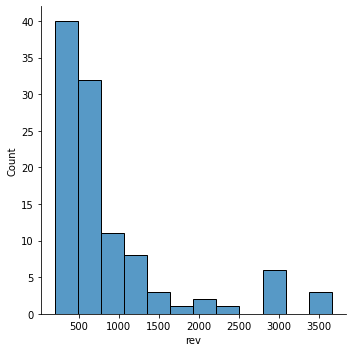

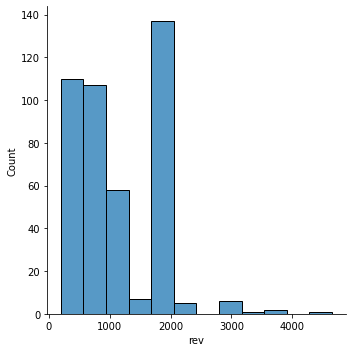

In [44]:
sns.displot(control.rev)
sns.displot(test.rev)

In [45]:
# Из графиков наглядно видно, что распределение не является нормальным

In [46]:
# С помощью боксплота проверим нет ли у нам значительных выбросов по контрольной и тестовой группах

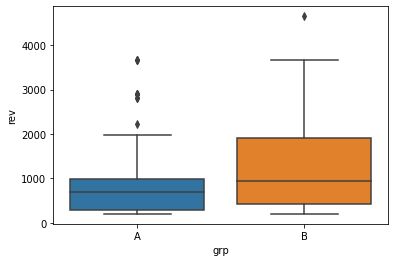

In [47]:
sns.boxplot(data=active_users.query('rev > 0'), x='grp', y='rev')

In [48]:
# Здесь можно увидеть, что присутствуют незначительные выбросы. 
# Для дальнейшего анализа выберем метод Bootstrap. 
# Примем 2 гипотезы:
#     Н0 - нет различия между контрольной и тестовой группами,
#     Н1 - средние значения различаются между группами

In [49]:
# функция для проверки гипотез с помощью бутстрапа
def get_bootstrap(
    data_column_1,                       # числовые значения первой (контрольной) выборки
    data_column_2,                       # числовые значения второй (тестовой) выборки
    boot_it=1000,                      # количество бутстрэп-подвыборок
    statistic=np.mean,                 # интересующая нас статистика
    bootstrap_conf_level=0.95,         # уровень значимости
    graph=True,                        # отрисовывать ли график
    show_progress=True                 # показывать ли индикатор програсса
                 ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    # выбираем отрисовывать индикатора програсса или нет
    if show_progress:
        progress_bar = tqdm
    else:
        progress_bar = lambda x: x
    
    for i in progress_bar(range(boot_it)):        # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace= True                        # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        samples_delta = samples_2 - samples_1        # находим разницу подвыборок
        boot_data.append(statistic(samples_delta))   # применяем статистику для разниц подвыборок
        
    pd_boot_data = pd.DataFrame(boot_data)

    # доверительный интервал 
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # отисовка графиков
    if graph == True:
        plt.hist(pd_boot_data[0], bins=50)
        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

In [50]:
# Посчитаем бутстрап для средних значений

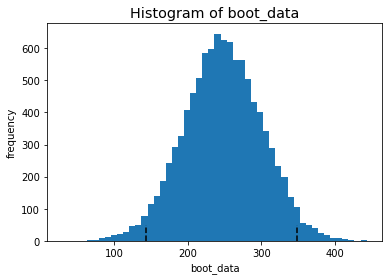

In [51]:
booted_data = get_bootstrap(control.rev,
                            test.rev,
                            boot_it=10000, 
                            statistic=np.mean,
                            bootstrap_conf_level=0.95)

In [52]:
booted_data["p_value"]

2.8695381199654546e-06

In [53]:
booted_data["ci"]

,0
0.025,142.839292
0.975,348.551390


In [54]:
# Здесь p-value < 0.05 следовательно необходимо отклонить нулевую гипотезу H0
# Так как наблюдались еще незначительные выбросы, проведем бутстрап для медианных значений

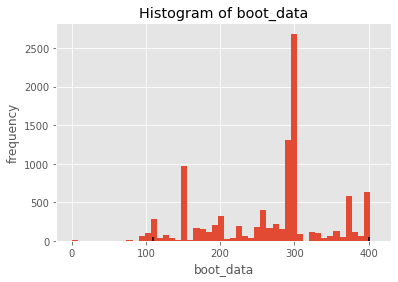

In [55]:
booted_data = get_bootstrap(control.rev,
                            test.rev,
                            boot_it=10000, 
                            statistic=np.median,
                            bootstrap_conf_level=0.95)

In [56]:
booted_data["p_value"]

0.0006686809016137424

In [57]:
booted_data["ci"]

,0
0.025,109.0
0.975,400.0


In [58]:
# Здесь тоже p-value < 0.05 следовательно необходимо отклонить нулевую гипотезу H0

Выводы:
1) Средний чек в тестовой группе увеличился на 248.11 (28.8%).
2) По данным bootstrap-анализа были выявлены статистически значимых различий между средними чеками в группах. Это значит, что можно запускать новую механику оплаты на всех пользователей
 

Задание 2. SQL
2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [59]:
# Подключимся к базе данных. Создаем словарь connection с нужными параметрами: для подключения к default:

In [60]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'}

In [61]:
# создаем запрос

In [62]:
q = ''' SELECT 
    count(st_id) as count_st
FROM
(
    SELECT 
        st_id
    FROM 
        peas
    WHERE
        correct = 1 and toStartOfMonth(timest) = '2020-03-01'
    GROUP BY 
        st_id, toDayOfMonth(timest), toHour(timest)
    HAVING
        sum(correct) > 20
)
'''

In [63]:
# отправляем запрос и записываем результат в пандасовский датафрейм

count_st = ph.read_clickhouse(query=q, connection=connection_default)
count_st

2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно
лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту
необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике.

In [64]:
# В данных представлена информация за 2020 год, для нашего анализа возьмем период с 01.07.2020 по 31.12.2020. 
# На основе данных произведем расчеты
# 1) ARPU - рассчитывается: общая сумма покупок / активные пользователи 
# (считаем активными тех, кто оплатил хотя бы один курс);
# 2) ARPAU - рассчитывается: общая сумма покупок / всех пользователей;
# 3) CR в покупку - число сконвертированных в покупку / общее число пользователей
# 4) СR активного пользователя в покупку  - число сконвертированных в покупку / число активных пользователей;
# (Так как за анализируемый период все пользователи, которые заходили на платформу оплатили,
# хотя бы один курс, то получается, что CR в покупку и СR активного пользователя в покупку это одно и тоже)
# 5) CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике. -
# число покупок по курсу "math"/ активные пользователи курса "math"

In [65]:
q2 = ''' SELECT 
    ar.test_grp as test_grp,
    ar.ARPU as ARPU,
    arp.ARPAU as ARPAU,
    crp.CR_in_purchase as CR_in_purchase,
    cra.CR_active as CR_active, 
    crm.CR_math as CR_math
FROM
(
    select test_grp,
        round(sum(money)/count(DISTINCT(st_id)),2) as ARPU
    from 
        (
        select 
            final_project_check.st_id, 
            toStartOfMonth(sale_time) as sale_time, 
            money,
            subject,
            studs.test_grp
        from final_project_check
        right semi join studs
        on final_project_check.st_id = studs.st_id
        WHERE sale_time >= '2020-07-01')
    group by test_grp
) as ar

JOIN

    (
    select test_grp, round(sum(money)/count(DISTINCT(st_id)),2) as ARPAU
    from 
            (
            select 
                final_project_check.st_id, 
                toStartOfMonth(sale_time) as sale_time, 
                money, subject, 
                studs.test_grp
            from final_project_check
            right semi join studs
            on final_project_check.st_id = studs.st_id
            WHERE sale_time >= '2020-07-01'
            ) as l
            right semi join 
            (select 
                st_id, 
                toStartOfMonth(timest) as timest, 
                subject
            from peas
            WHERE timest >= '2020-07-01'
            ) as b
            on l.st_id = b.st_id
    group by test_grp
    ) as arp
on ar.test_grp = arp.test_grp


JOIN

(
    select test_grp, count(DISTINCT(b.st_id)) *100 / count(DISTINCT(st_id))  as CR_in_purchase
    from 
        (
        select 
            final_project_check.st_id,
            toStartOfMonth(sale_time) as sale_time, 
            money, subject, 
            studs.test_grp
        from final_project_check
        right semi join studs
        on final_project_check.st_id = studs.st_id
        WHERE sale_time >= '2020-07-01'
        ) as l
        right semi join 
        (
            select 
                st_id,
                toStartOfMonth(timest) as timest, 
                subject
            from peas
            WHERE timest >= '2020-07-01'
        ) as b
        on l.st_id = b.st_id

    group by test_grp
) as crp

on ar.test_grp = crp.test_grp

JOIN

(
select 
    test_grp, 
    count(DISTINCT(b.st_id)) *100 / count(DISTINCT(st_id))  as CR_active
from 
    (
    select 
        final_project_check.st_id, 
        toStartOfMonth(sale_time) as sale_time,
        money, 
        subject, 
        studs.test_grp
    from final_project_check
    right semi join studs
    on final_project_check.st_id = studs.st_id
    WHERE sale_time >= '2020-07-01'
    ) as l
    right semi join 
    (
    select 
        st_id,
        toStartOfMonth(timest) as timest, 
        subject
    from peas
    WHERE timest >= '2020-07-01'
    ) as b
    on l.st_id = b.st_id
group by test_grp
) as cra
on ar.test_grp = cra.test_grp

JOIN
(
    select 
        test_grp, 
        round(CAST(st_id_buyer as FLOAT) * 100 / CAST(st_id_active as FLOAT), 2) as CR_math
    from
    (
        select 
            test_grp, 
            count(distinct(st_id)) as st_id_active
        from
        (
        select 
            st_id, 
            toStartOfMonth(timest) as timest, 
            subject
        from peas
        WHERE timest >= '2020-07-01' and subject = 'Math') as n
        right semi join studs
        on n.st_id = studs.st_id
        group by test_grp 
    ) as k
    join 
    (
     select 
         test_grp, 
         count(distinct(st_id)) as st_id_buyer
    from 
        (
        select 
            final_project_check.st_id,
            toStartOfMonth(sale_time) as sale_time,
            money, 
            subject
        from final_project_check
        WHERE sale_time >= '2020-07-01' and subject = 'Math') as t
        right semi join studs
        on t.st_id = studs.st_id
        
    group by test_grp
    ) as u
    on k.test_grp = u.test_grp
) as crm

on ar.test_grp = crm.test_grp
'''

In [66]:
metric = ph.read_clickhouse(query=q2, connection=connection_default)
metric

,test_grp,ARPU,ARPAU,CR_in_purchase,CR_active,CR_math
0,new,62692.31,64423.08,100.0,100.0,84.62
1,old,58518.52,25000.00,100.0,100.0,84.62


Задание 3. Python
3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [67]:
# Создадим функцию, которая будет автоматически подгружать информацию из дополнительного файла

In [68]:
def metrics(groups, groups_add, active_studs, checks):
    #     объединим таблицы
    groups_full = pd.concat([groups, groups_add], ignore_index=True)  
    
    #     так как в условиях указано, что заголовки могут отличатся переименуем их
    
    active_studs.rename(columns={'student_id': 'id'}, inplace=True)
    checks.rename(columns={'student_id': 'id'}, inplace=True)
    
    active_studs['activity_status'] = 1
    df = checks.merge(active_studs, how='left', on='id').query('activity_status != 1').fillna(0)
    
    full_users = pd.merge(groups_full, active_studs, how='left', on='id')
    full_users = pd.merge(full_users, checks, how='left', on='id')
    full_users = full_users.fillna(0)
    
    active_users = full_users.query('activity_status > 0 or rev > 0')
    
    revenue = active_users.groupby('grp', as_index=False) \
                .agg({'rev': 'sum'}).round(2).rename(columns={'rev': 'revenue'})
    groups_user = active_users.groupby('grp', as_index=False) \
                .agg({'id': 'count'}).rename(columns={'id': 'users'})
    groups_buyers = active_users.query('rev > 0').groupby('grp', as_index=False) \
                .agg({'id': 'count'}).rename(columns={'id': 'buyers'})
    
    all_metrics = groups_user.merge(groups_buyers).merge(revenue)
    
    all_metrics['avg_check'] = (all_metrics.revenue / all_metrics.buyers).round(2)
    all_metrics['ARPU'] = (all_metrics.revenue / all_metrics.users).round(2)
    all_metrics['ARPPU'] = (all_metrics.revenue / all_metrics.buyers).round(2)
    all_metrics['CR'] = (all_metrics.buyers / all_metrics.users)
    
    return all_metrics

In [69]:
all_metrics = metrics(groups, groups_add, active_studs, checks)
all_metrics

,grp,users,buyers,revenue,avg_check,ARPU,ARPPU,CR
0,A,1567,107,92096.0,860.71,58.77,860.71,0.068283
1,B,6923,434,481230.0,1108.82,69.51,1108.82,0.062690


In [70]:
# Создадим функцию, которая будет строить графики

In [71]:
def charts(df):
    sns.set(rc={'figure.figsize': (7, 4)})
    sns.barplot(x="grp", y='CR', data=df)
    plt.title("CR")
    plt.xlabel('Group')
    plt.ylabel('CR, %')
    plt.show()

    sns.barplot(x="grp", y="ARPU", data=df)
    plt.title("ARPU")
    plt.xlabel('Group')
    plt.ylabel('ARPU')
    plt.show()

    sns.barplot(x="grp", y="ARPPU", data=df)
    plt.xlabel('Group')
    plt.ylabel('ARPPU')
    plt.title ("ARPPU")
    plt.show()

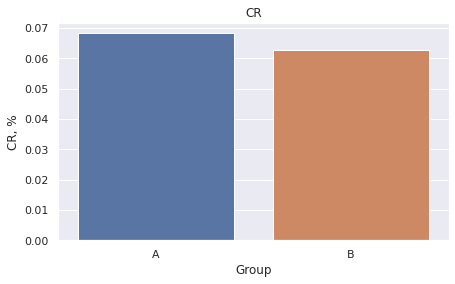

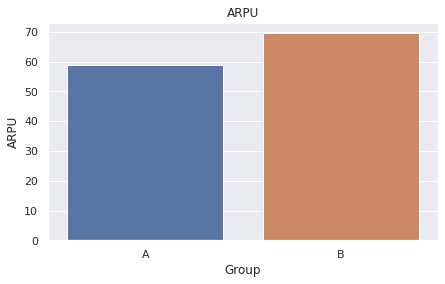

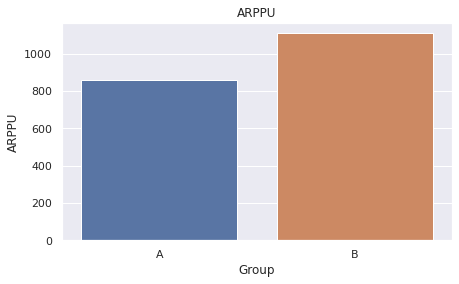

In [72]:
charts(all_metrics)